In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import json
from IPython.core.display import display, HTML
import tempfile

from math import sqrt
import scipy.stats
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree

import xgboost as xgb

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [4]:
df_results=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fifa/results.csv")
df_results.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Glasgow,Scotland,False
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,London,England,False
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wrexham,Wales,False
8,1878-03-02,Scotland,England,7.0,2.0,Friendly,Glasgow,Scotland,False
9,1878-03-23,Scotland,Wales,9.0,0.0,Friendly,Glasgow,Scotland,False


In [5]:
df_shootouts=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fifa/shootouts.csv")

In [6]:
df_player15=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/fifa/players/Career Mode player datasets - FIFA 15-22.xlsx", sheet_name=0)

In [7]:
df_results15=df_results.loc[df_results['date']>='2015-01-01'].loc[df_results['date']<'2016-01-01']
df_results15.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
36970,2015-01-04,Bahrain,Jordan,1.0,0.0,Friendly,Ballarat,Australia,True
36971,2015-01-04,Iran,Iraq,1.0,0.0,Friendly,Wollongong,Australia,True
36972,2015-01-04,South Korea,Saudi Arabia,2.0,0.0,Friendly,Parramatta,Australia,True
36973,2015-01-04,South Africa,Zambia,1.0,0.0,Friendly,Johannesburg,South Africa,False
36974,2015-01-05,China PR,Oman,4.0,1.0,Friendly,Penrith,Australia,True
36975,2015-01-07,Cameroon,DR Congo,1.0,1.0,Friendly,Yaoundé,Cameroon,False
36976,2015-01-09,Australia,Kuwait,4.0,1.0,AFC Asian Cup,Melbourne,Australia,False
36977,2015-01-09,Senegal,Gabon,1.0,0.0,Friendly,Casablanca,Morocco,True
36978,2015-01-10,Burkina Faso,Eswatini,5.0,1.0,Friendly,Nelspruit,South Africa,True
36979,2015-01-10,Cameroon,South Africa,1.0,1.0,Friendly,Libreville,Gabon,True


In [8]:
df_player15['rank_in_nation'] = df_player15.groupby("nationality_name")['value_eur'].rank(method="first", ascending=False)
df_player15['rank_in_nation'] = df_player15['rank_in_nation'].astype('Int64')
df_player15.sort_values('value_eur', ascending=False)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,rank_in_nation
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,...,45+3,45+3,54+3,15+3,https://cdn.sofifa.net/players/158/023/15_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png,1
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,...,52+3,52+3,57+3,16+3,https://cdn.sofifa.net/players/020/801/15_120.png,https://cdn.sofifa.net/teams/243/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png,1
4,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,90,90,63500000.0,300000.0,28,...,38+3,38+3,36+3,87+3,https://cdn.sofifa.net/players/167/495/15_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,1
2,9014,https://sofifa.com/player/9014/arjen-robben/15...,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,...,46+3,46+3,55+3,14+3,https://cdn.sofifa.net/players/009/014/15_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/105035/60.png,https://cdn.sofifa.net/flags/nl.png,1
3,41236,https://sofifa.com/player/41236/zlatan-ibrahim...,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,52500000.0,275000.0,32,...,55+3,55+3,56+3,17+3,https://cdn.sofifa.net/players/041/236/15_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1363/60.png,https://cdn.sofifa.net/flags/se.png,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15200,174441,https://sofifa.com/player/174441/rocus-lamare/...,R. Lamare,Rocus Lamare,CM,52,55,NaN,NaN,27,...,52,52,53,13,https://cdn.sofifa.net/players/174/441/15_120.png,NaN,NaN,https://cdn.sofifa.net/teams/111466/60.png,https://cdn.sofifa.net/flags/in.png,<NA>
15452,225444,https://sofifa.com/player/225444/joel-stevens/...,J. Stevens,Joel Craig Stevens,"RM, CAM",52,56,NaN,NaN,19,...,35,35,37,10,https://cdn.sofifa.net/players/225/444/15_120.png,NaN,NaN,https://cdn.sofifa.net/teams/111473/60.png,https://cdn.sofifa.net/flags/nz.png,<NA>
15534,216751,https://sofifa.com/player/216751/diego-bejaran...,D. Bejarano,Diego Bejarano Ibañez,"RB, CB, RM",51,54,NaN,NaN,22,...,52,52,51,14,https://cdn.sofifa.net/players/216/751/15_120.png,NaN,NaN,https://cdn.sofifa.net/teams/111451/60.png,https://cdn.sofifa.net/flags/bo.png,<NA>
15806,223760,https://sofifa.com/player/223760/amrinder-sing...,A. Singh,Amrinder Singh,GK,50,54,NaN,NaN,21,...,31,31,28,50,https://cdn.sofifa.net/players/223/760/15_120.png,NaN,NaN,https://cdn.sofifa.net/teams/111466/60.png,https://cdn.sofifa.net/flags/in.png,<NA>


In [34]:
df_player15_wage = df_player15
df_player15_wage['rank_in_nation'] = df_player15_wage.groupby("nationality_name")['wage_eur'].rank(method="first", ascending=False)
df_player15_wage['rank_in_nation'] = df_player15_wage['rank_in_nation'].astype('Int64')
df_player15_wage.sort_values('wage_eur', ascending=False)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,rank_in_nation
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,...,45+3,45+3,54+3,15+3,https://cdn.sofifa.net/players/158/023/15_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png,1
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,...,52+3,52+3,57+3,16+3,https://cdn.sofifa.net/players/020/801/15_120.png,https://cdn.sofifa.net/teams/243/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png,1
4,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,90,90,63500000.0,300000.0,28,...,38+3,38+3,36+3,87+3,https://cdn.sofifa.net/players/167/495/15_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,1
6,176580,https://sofifa.com/player/176580/luis-suarez/1...,L. Suárez,Luis Alberto Suárez Díaz,"ST, CF",89,91,49500000.0,300000.0,27,...,57+3,57+3,62+3,34+3,https://cdn.sofifa.net/players/176/580/15_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/uy.png,1
2,9014,https://sofifa.com/player/9014/arjen-robben/15...,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,...,46+3,46+3,55+3,14+3,https://cdn.sofifa.net/players/009/014/15_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/105035/60.png,https://cdn.sofifa.net/flags/nl.png,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15073,220542,https://sofifa.com/player/220542/romel-quinone...,R. Quiñonez,Romel Javier Quiñónez Suárez,GK,53,61,NaN,NaN,22,...,30,30,28,53,https://cdn.sofifa.net/players/220/542/15_120.png,NaN,NaN,https://cdn.sofifa.net/teams/111451/60.png,https://cdn.sofifa.net/flags/bo.png,<NA>
15200,174441,https://sofifa.com/player/174441/rocus-lamare/...,R. Lamare,Rocus Lamare,CM,52,55,NaN,NaN,27,...,52,52,53,13,https://cdn.sofifa.net/players/174/441/15_120.png,NaN,NaN,https://cdn.sofifa.net/teams/111466/60.png,https://cdn.sofifa.net/flags/in.png,<NA>
15452,225444,https://sofifa.com/player/225444/joel-stevens/...,J. Stevens,Joel Craig Stevens,"RM, CAM",52,56,NaN,NaN,19,...,35,35,37,10,https://cdn.sofifa.net/players/225/444/15_120.png,NaN,NaN,https://cdn.sofifa.net/teams/111473/60.png,https://cdn.sofifa.net/flags/nz.png,<NA>
15534,216751,https://sofifa.com/player/216751/diego-bejaran...,D. Bejarano,Diego Bejarano Ibañez,"RB, CB, RM",51,54,NaN,NaN,22,...,52,52,51,14,https://cdn.sofifa.net/players/216/751/15_120.png,NaN,NaN,https://cdn.sofifa.net/teams/111451/60.png,https://cdn.sofifa.net/flags/bo.png,<NA>


In [36]:
df_player15_wage = pd.DataFrame(df_player15_wage, columns=['short_name','nationality_name','nationality_id', 'wage_eur', 'rank_in_nation'])
df_player15_wage.head()

,short_name,nationality_name,nationality_id,wage_eur,rank_in_nation
0,L. Messi,Argentina,52,550000.0,1
1,Cristiano Ronaldo,Portugal,38,375000.0,1
2,A. Robben,Netherlands,34,275000.0,1
3,Z. Ibrahimović,Sweden,46,275000.0,1
4,M. Neuer,Germany,21,300000.0,1


In [9]:
df_player15_selected = pd.DataFrame(df_player15, columns=['short_name','nationality_name','nationality_id', 'value_eur', 'rank_in_nation'])
df_player15_selected.head()
# rank_in_nation : 각 국가팀에서 이 선수가 몇번째로 돈 잘버는지 순위 

,short_name,nationality_name,nationality_id,value_eur,rank_in_nation
0,L. Messi,Argentina,52,100500000.0,1
1,Cristiano Ronaldo,Portugal,38,79000000.0,1
2,A. Robben,Netherlands,34,54500000.0,1
3,Z. Ibrahimović,Sweden,46,52500000.0,1
4,M. Neuer,Germany,21,63500000.0,1


In [11]:
# 'sofifa_id','short_name','long_name','vallue_eur','wage_eur','age','dob','nationality_id','nationality_name','nation_team_id','nation_position','nation_jersey_number','preferred_foot','weak_foot','skill_moves','international_reputation','pace'

df_player15_edited = pd.DataFrame(df_player15_selected, columns=['nationality_name', 'player1_value_eur']) # 'player1_wage_eur'

for i in range(2,4):
    col1 = 'player' + str(i) + '_value_eur'
   # col2 = 'player' + str(i) + '_wage_eur'
    df_player15_edited[col1] = np.nan
   # df_player15_edited[col2] = np.nan

#print(df_player15_edited)
df_player15_edited.head()

,nationality_name,player1_value_eur,player2_value_eur,player3_value_eur
0,Argentina,NaN,NaN,NaN
1,Portugal,NaN,NaN,NaN
2,Netherlands,NaN,NaN,NaN
3,Sweden,NaN,NaN,NaN
4,Germany,NaN,NaN,NaN


In [12]:
df_player15.iloc[0]['sofifa_id']

158023

In [13]:
nationality_ids = df_player15_selected['nationality_id'].tolist()

In [14]:
len(nationality_ids)

16155

In [16]:
df_player15_edited.head()

,nationality_name,player1_value_eur,player2_value_eur,player3_value_eur
0,Argentina,NaN,NaN,NaN
1,Portugal,NaN,NaN,NaN
2,Netherlands,NaN,NaN,NaN
3,Sweden,NaN,NaN,NaN
4,Germany,NaN,NaN,NaN


In [17]:
nationality_names = df_player15_selected['nationality_name'].tolist()

In [18]:
for i in nationality_names:
  players = []
  players.append(i)
  for j in range(1, 4): # player1, 2, 3값만 가져오기 
    try:
      players.append(df_player15.loc[df_player15['rank_in_nation'] == j].loc[df_player15['nationality_name'] == i]['value_eur'].item())
      if j == 3:
        df_player15_edited.loc[df_player15_edited['nationality_name'] == i] = players
    except:
      continue

In [19]:
df_player15_edited.head()

,nationality_name,player1_value_eur,player2_value_eur,player3_value_eur
0,Argentina,100500000.0,45500000.0,45500000.0
1,Portugal,79000000.0,16500000.0,13500000.0
2,Netherlands,54500000.0,40500000.0,21000000.0
3,Sweden,52500000.0,9000000.0,7500000.0
4,Germany,63500000.0,44000000.0,40000000.0


Ranking Data

In [20]:
df_rankings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fifa/fifa_ranking.csv')

In [21]:
df_rankings = df_rankings.replace({"IR Iran":"Iran"})
df_rankings['weighted_points'] = df_rankings['cur_year_avg_weighted'] + df_rankings['two_year_ago_weighted'] + df_rankings['three_year_ago_weighted']
df_rankings['rank_date'] = pd.to_datetime(df_rankings['rank_date'])

In [22]:
df_rankings = df_rankings.query("rank_date >= '2015-01-01' and rank_date <= '2015-12-31'").reset_index(drop=True)
df_rankings.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,weighted_points
0,1,Germany,GER,1725.29,1725,0,1090.54,1090.54,566.83,283.42,765.86,229.76,607.88,121.58,UEFA,2015-01-08,1441.88
1,2,Argentina,ARG,1538.29,1538,0,937.59,937.59,590.90,295.45,733.76,220.13,425.62,85.12,CONMEBOL,2015-01-08,1242.84
2,3,Colombia,COL,1449.77,1450,0,805.97,805.97,632.31,316.15,794.27,238.28,446.83,89.37,CONMEBOL,2015-01-08,1133.62
3,4,Belgium,BEL,1417.27,1417,0,849.03,849.03,652.93,326.46,542.17,162.65,395.59,79.12,UEFA,2015-01-08,1090.80
4,5,Netherlands,NED,1374.24,1374,0,884.29,884.29,527.71,263.86,428.54,128.56,487.68,97.54,UEFA,2015-01-08,1110.39


In [23]:
df_rankings = df_rankings.rename(columns = {"country_full":"nationality_name"})

In [24]:

new_df = pd.merge(df_rankings, df_player15_edited, how='right',on='nationality_name')
new_df.head()

,rank,nationality_name,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,weighted_points,player1_value_eur,player2_value_eur,player3_value_eur
0,2.0,Argentina,ARG,1538.29,1538.0,0.0,937.59,937.59,590.90,295.45,733.76,220.13,425.62,85.12,CONMEBOL,2015-01-08,1242.84,100500000.0,45500000.0,45500000.0
1,2.0,Argentina,ARG,1534.20,1538.0,0.0,937.59,937.59,595.26,297.63,717.86,215.36,418.10,83.62,CONMEBOL,2015-02-12,1236.57,100500000.0,45500000.0,45500000.0
2,2.0,Argentina,ARG,1577.19,1534.0,0.0,992.63,992.63,559.57,279.79,732.94,219.88,424.48,84.90,CONMEBOL,2015-03-12,1297.41,100500000.0,45500000.0,45500000.0
3,2.0,Argentina,ARG,1490.04,1577.0,0.0,919.87,919.87,512.98,256.49,742.10,222.63,455.26,91.05,CONMEBOL,2015-04-09,1233.55,100500000.0,45500000.0,45500000.0
4,2.0,Argentina,ARG,1493.70,1490.0,0.0,919.87,919.87,512.98,256.49,742.10,222.63,473.57,94.71,CONMEBOL,2015-05-07,1237.21,100500000.0,45500000.0,45500000.0


In [25]:
new_df = pd.DataFrame(new_df, columns=['total_points','player1_value_eur', 'player2_value_eur', 'player3_value_eur'])

Heatmap 만들기 - player의 value_eur 와 ranking의 total_points 간의 correlation

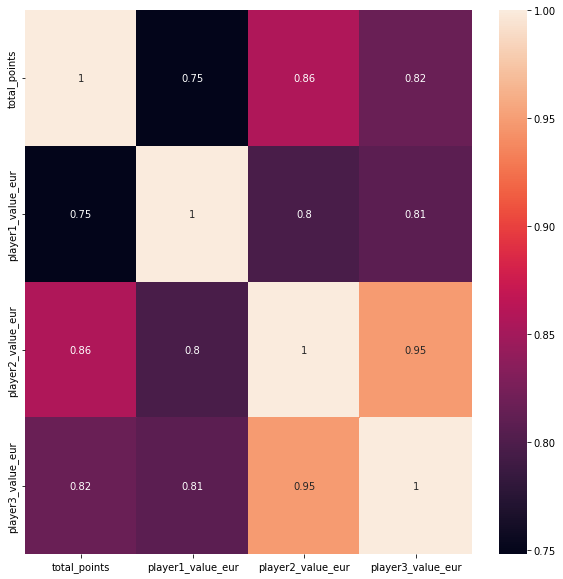

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
corr1 = new_df.corr()
sns.heatmap(corr1, annot=True)

Heatmap 2 - player wage와 ranking의 correlation

In [37]:
df_player15_wage.head()

,short_name,nationality_name,nationality_id,wage_eur,rank_in_nation
0,L. Messi,Argentina,52,550000.0,1
1,Cristiano Ronaldo,Portugal,38,375000.0,1
2,A. Robben,Netherlands,34,275000.0,1
3,Z. Ibrahimović,Sweden,46,275000.0,1
4,M. Neuer,Germany,21,300000.0,1


In [39]:

df_player15_edited_2 = pd.DataFrame(df_player15_wage, columns=['nationality_name', 'player1_wage_eur']) # 'player1_wage_eur'

for i in range(2,4):
    col = 'player' + str(i) + '_wage_eur'
    df_player15_edited_2[col] = np.nan

df_player15_edited_2.head()

,nationality_name,player1_wage_eur,player2_wage_eur,player3_wage_eur
0,Argentina,NaN,NaN,NaN
1,Portugal,NaN,NaN,NaN
2,Netherlands,NaN,NaN,NaN
3,Sweden,NaN,NaN,NaN
4,Germany,NaN,NaN,NaN


In [42]:
for i in nationality_names:
  players = []
  players.append(i)
  for j in range(1, 4): # player1, 2, 3값만 가져오기 
    try:
      players.append(df_player15_wage.loc[df_player15_wage['rank_in_nation'] == j].loc[df_player15_wage['nationality_name'] == i]['wage_eur'].item())
      if j == 3:
        df_player15_edited_2.loc[df_player15_edited_2['nationality_name'] == i] = players
    except:
      continue

In [44]:
new_df2 = pd.merge(df_rankings, df_player15_edited_2, how='right',on='nationality_name')
new_df2.tail()

,rank,nationality_name,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,weighted_points,player1_wage_eur,player2_wage_eur,player3_wage_eur
189521,8.0,England,ENG,1156.83,1157.0,1.0,705.38,705.38,411.37,205.69,350.91,105.27,702.50,140.50,UEFA,2015-08-06,951.15,230000.0,150000.0,120000.0
189522,10.0,England,ENG,1142.82,1157.0,-2.0,705.38,705.38,408.40,204.20,338.91,101.67,657.88,131.58,UEFA,2015-09-03,938.63,230000.0,150000.0,120000.0
189523,10.0,England,ENG,1160.67,1143.0,0.0,692.90,692.90,473.57,236.79,353.68,106.10,624.38,124.88,UEFA,2015-10-01,923.88,230000.0,150000.0,120000.0
189524,9.0,England,ENG,1179.13,1161.0,1.0,713.69,713.69,392.41,196.20,496.41,148.92,601.57,120.31,UEFA,2015-11-05,982.92,230000.0,150000.0,120000.0
189525,9.0,England,ENG,1105.71,1179.0,0.0,595.78,595.78,523.32,261.66,455.04,136.51,558.77,111.75,UEFA,2015-12-03,844.04,230000.0,150000.0,120000.0


In [46]:
new_df2 = pd.DataFrame(new_df2, columns=['total_points','player1_wage_eur', 'player2_wage_eur', 'player3_wage_eur'])

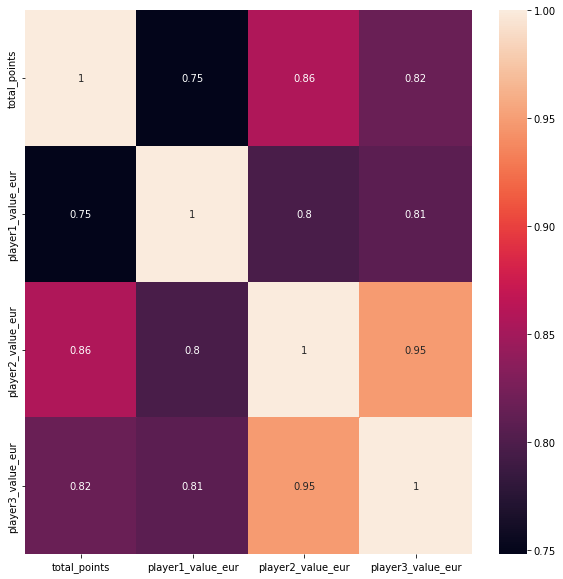

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
corr2 = new_df.corr()
sns.heatmap(corr2, annot=True)

희민님 원래 코드

In [27]:
df_player15.loc[df_player15['rank_in_nation']==1].loc[df_player15['nationality_id'] == 52]['value_eur'].iloc[0]

100500000.0

In [28]:
player = [52,]
for j in range(1, 12):
    player.append(df_player15.loc[df_player15['rank_in_nation'] == j].loc[df_player15['nationality_id'] == 52]['value_eur'].item())
    player.append(df_player15.loc[df_player15['rank_in_nation']==j].loc[df_player15['nationality_id']== 52]['wage_eur'].item())
    df_player15_edited.loc[len(df_player15_edited.index)] = player


ValueError: ignored

In [ ]:
df_player15.loc[df_player15['rank_in_nation'] == 2].loc[df_player15['nationality_id'] == 52]['value_eur']

In [ ]:
# home_score away_score home_player1_wage home_player2_wage home_player3_wage ... home_player11_wage away_player1_wage ... away_player11_wage